In [50]:
import numpy as np
from filterpy.kalman import KalmanFilter
import pandas as pd
import matplotlib.pyplot as plt
import quaternion
from mpl_toolkits.mplot3d import Axes3D


# Orientation estimation using extended kalman filter
  Based on: X. Yun and E. R. Bachmann, ‘Design, Implementation, and Experimental Results of a Quaternion-Based Kalman Filter for Human Body Motion Tracking’, IEEE Trans. Robot., vol. 22, no. 6, pp. 1216–1227, Dec. 2006, doi: 10.1109/TRO.2006.886270.
  
The state vector contains 3D angular velocity and quaternion: $$
\vec{x} = \begin{pmatrix} \omega_x & \omega_y & \omega_z & q_1 & q_2 & q_3 & q_4 \end{pmatrix}^T
$$


In [51]:
# this is the Jacobian (linearized version) of the state transition, equation (13)
def phi(x, Ts, tau1, tau2, tau3):
    return np.array([[np.exp(-Ts/tau1), 0, 0, 0, 0, 0, 0],
                    [0, np.exp(-Ts/tau2), 0, 0, 0, 0, 0],
                    [0, 0, np.exp(-Ts/tau3), 0, 0, 0, 0],
                    [-(x[4]*Ts)/2, -(x[5]*Ts)/2, -(x[6]*Ts)/2, 1, -(x[0]*Ts)/2, -(x[1]*Ts)/2, -(x[2]*Ts)/2],
                    [(x[3]*Ts)/2, -(x[6]*Ts)/2, (x[5]*Ts)/2, (x[0]*Ts)/2, 1, (x[2]*Ts)/2, -(x[1]*Ts)/2],
                    [(x[6]*Ts)/2, (x[3]*Ts)/2, -(x[4]*Ts)/2, (x[1]*Ts)/2, -(x[2]*Ts)/2, 1, (x[0]*Ts)/2],
                    [-(x[5]*Ts)/2, (x[4]*Ts)/2, (x[3]*Ts)/2, (x[2]*Ts)/2, (x[1]*Ts)/2, -(x[0]*Ts)/2, 1]])

def quaternion_to_matrix(q):
    w, x, y, z = q
    return np.array([
        [1 - 2 * y ** 2 - 2 * z ** 2, 2 * x * y - 2 * z * w, 2 * x * z + 2 * y * w],
        [2 * x * y + 2 * z * w, 1 - 2 * x ** 2 - 2 * z ** 2, 2 * y * z - 2 * x * w],
        [2 * x * z - 2 * y * w, 2 * y * z + 2 * x * w, 1 - 2 * x ** 2 - 2 * y ** 2]
    ])

def normalize_quaternion(q):
    norm = np.linalg.norm(q)
    if norm > 1e-10:
       q = q / norm
    return q
        
def update_velocity(v, accel, R, Ts):
    # transform to world frame
    accel_world = R @ accel
    # integrate acceleration to velocity
    v_new = v + accel_world * Ts
    return v_new


In [52]:
kf = KalmanFilter(dim_x=7,dim_z=7)
kf.x = np.array([0,0,0,0,0,0,0])
Ts = 0.04  # 25Hz samples

kf.H = np.eye(7)

tau1 = 0.7
tau2 = 0.7
tau3 = 0.7
D = 0.1

q11 = (D/(2*tau1))*(1 - np.exp(-(2*Ts)/tau1))
q22 = (D/(2*tau1))*(1 - np.exp(-(2*Ts)/tau2))
q33 = (D/(2*tau1))*(1 - np.exp(-(2*Ts)/tau3))
q_quat = 0.001

kf.Q = np.array([
    [q11, 0, 0, 0, 0, 0, 0],
    [0, q22, 0, 0, 0, 0, 0],
    [0, 0, q33, 0, 0, 0, 0],
    [0, 0, 0, q_quat, 0, 0, 0],
    [0, 0, 0, 0, q_quat, 0, 0],
    [0, 0, 0, 0, 0, q_quat, 0],
    [0, 0, 0, 0, 0, 0, q_quat]])

kf.R =  np.array([
    [0.01, 0, 0, 0, 0, 0, 0],
    [0, 0.01, 0, 0, 0, 0, 0],
    [0, 0, 0.01, 0, 0, 0, 0],
    [0, 0, 0, 0.0001, 0, 0, 0],
    [0, 0, 0, 0, 0.0001, 0, 0],
    [0, 0, 0, 0, 0, 0.0001, 0],
    [0, 0, 0, 0, 0, 0, 0.0001]])

kf.P *= 1000

In [53]:
df_stationary = pd.read_csv('spiral_data/sensor_stand_still.csv')
Ax_Bias = df_stationary['a_x'].mean()
Ay_Bias = df_stationary['a_y'].mean()
Az_Bias = df_stationary['a_z'].mean()
Gx_Bias = df_stationary['omega_x'].mean()
Gy_Bias = df_stationary['omega_y'].mean()
Gz_Bias = df_stationary['omega_z'].mean()

In [54]:
# Initial position and velocity
initial_position = np.array([0.0, 0.0, 0.0])
positions = [initial_position]  # Store the initial position
current_position = initial_position

# Store positions for plotting
measured_positions = []
predicted_positions = []
predicted_quaternions = []
accelerations = []

df = pd.read_csv('spiral_data/sensor_data_down_b.csv')
v=np.array([0.0,0,0])
for i, row in df.iterrows():
    # z y x
    z = [row['Gyro_X']*(np.pi/180),
         row['Gyro_X']*(np.pi/180),
         row['Gyro_X']*(np.pi/180),
         row['Quaternion_W'], 
         row['Quaternion_X'], 
         row['Quaternion_Y'], 
         row['Quaternion_Z']]
    
    z[3:7] = normalize_quaternion(z[3:7])
    kf.F = phi(kf.x, Ts, tau1, tau2, tau3)  # Predict with Kalman filter
    kf.predict()
    kf.update(z)
    
        

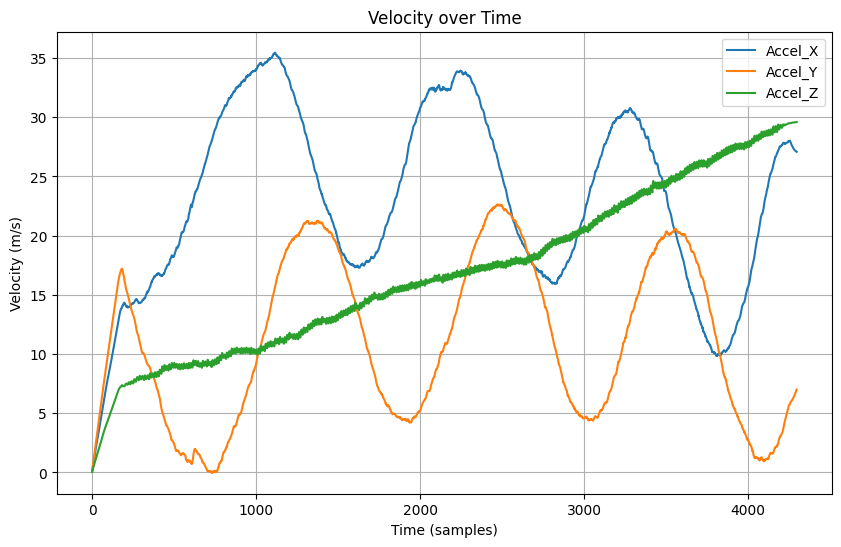

In [55]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(accelerations[:,0], label='Accel_X')
plt.plot(accelerations[:,1], label='Accel_Y')
plt.plot(accelerations[:,2], label='Accel_Z')

# Add labels, legend, and grid
plt.xlabel('Time (samples)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity over Time')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

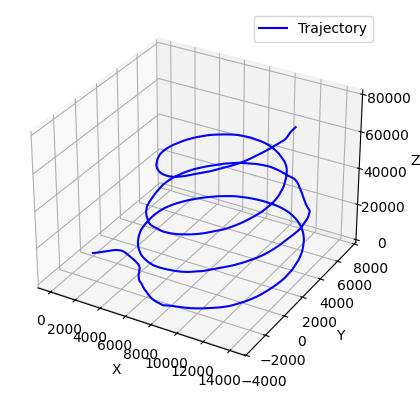

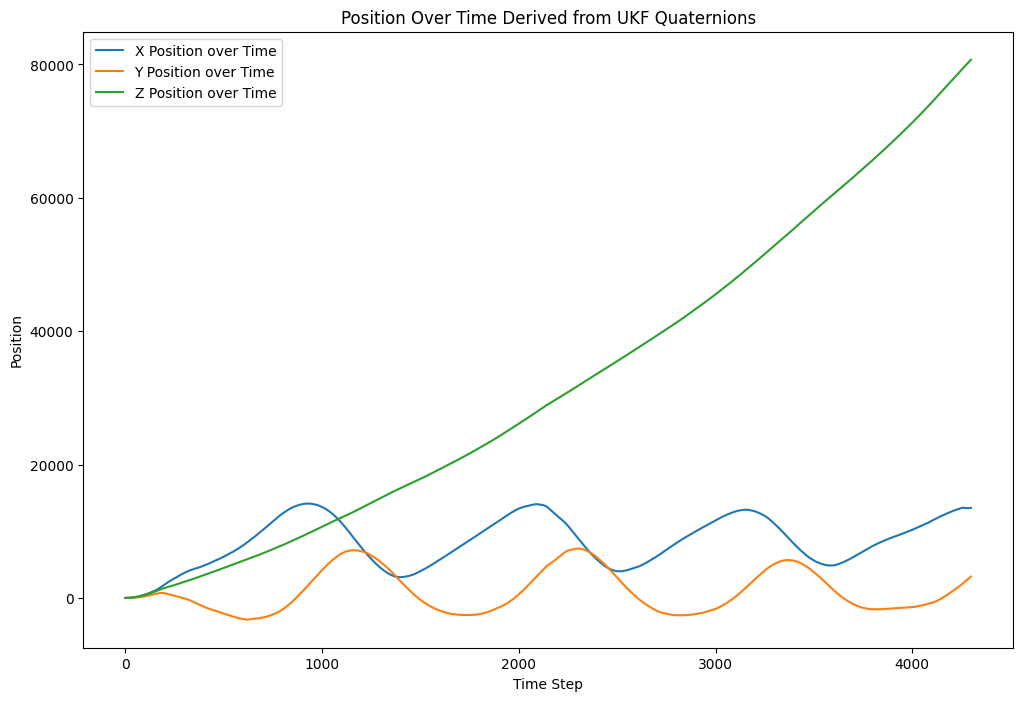

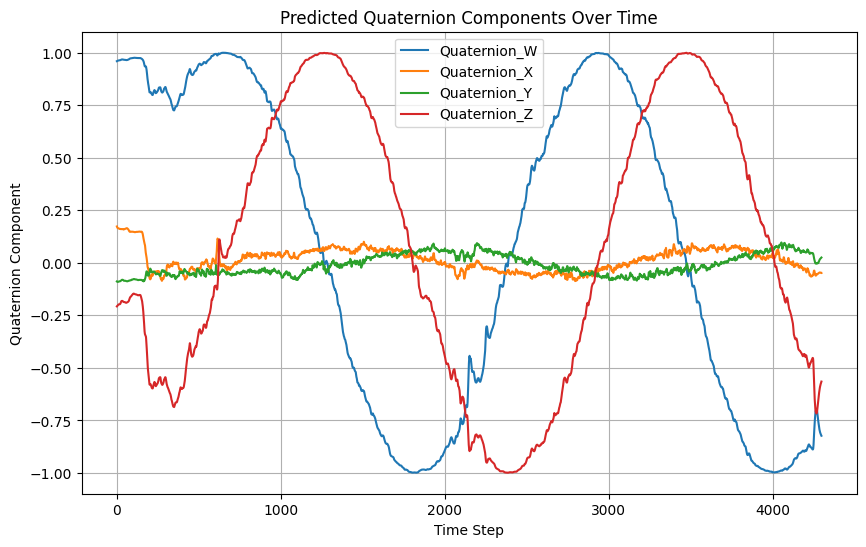

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot measured position
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label='Trajectory', color='blue')

# Plot predicted positions
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()

# Plot positions over time
plt.figure(figsize=(12, 8))
plt.plot(positions[:, 0], label='X Position over Time')
plt.plot(positions[:, 1], label='Y Position over Time')
plt.plot(positions[:, 2], label='Z Position over Time')
plt.title('Position Over Time Derived from UKF Quaternions')
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(predicted_quaternions[:, 0], label='Quaternion_W')
plt.plot(predicted_quaternions[:, 1], label='Quaternion_X')
plt.plot(predicted_quaternions[:, 2], label='Quaternion_Y')
plt.plot(predicted_quaternions[:, 3], label='Quaternion_Z')
plt.xlabel('Time Step')
plt.ylabel('Quaternion Component')
plt.title('Predicted Quaternion Components Over Time')
plt.legend()
plt.grid()
plt.show()
